In [203]:
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplots_per_method(df, y_cap, y_cap_r, metric, save_path, overflow_pairs=None, models_order=None, methods_order=None):
    """
    Boxplots of fold-wise MAE scores per (OF method, CNN model) combination.
    """
    # --- orderings ---
    if models_order is None:
        models_order = list(df["Model"].drop_duplicates())
    if methods_order is None:
        methods_order = list(df["OF Method"].drop_duplicates())

    grouped = (
        df.groupby(["Model","OF Method"])[metric]
        .apply(lambda s: np.asarray(s.dropna().values, dtype=float))
        .to_dict()
    )

    # others = []
    # for m in models_order:
    #     for me in methods_order:
    #         if (m, me) in overflow_pairs:
    #             continue
    #         v = grouped.get((m, me), np.array([], dtype=float))
    #         if v.size:
    #             others.append(v)
    
    # positions per group
    G = len(models_order)
    M = len(methods_order)
    inter_gap = 1.0  # empty slot between groups
    # group g occupies positions: g*(M+inter_gap) + 1 .. + M
    def pos(g, i):
        return g * (M + inter_gap) + (i + 1)

    # ---- Colors: one per method (consistent across groups) ----
    cmap = plt.get_cmap("Pastel1")
    method_colors = {me: cmap(i % cmap.N) for i, me in enumerate(methods_order)}

    # ---- Plot main axies ----
    fig = plt.figure(figsize=(max(8, 1.2*G + 0.9*M), 6), dpi=300)
    gs  = GridSpec(nrows=1, ncols=3, width_ratios=[14, 1, 1], wspace=0.12, figure=fig)
    ax  = fig.add_subplot(gs[0])   # main axis
    ax_r_1 = fig.add_subplot(gs[1])
    ax_r_2 = fig.add_subplot(gs[2])  # right sidebar for overflow pair

    # Draw box for each (model, method) present
    for g, m in enumerate(models_order):
        for i, me in enumerate(methods_order):
            v = grouped.get((m, me), np.array([], dtype=float))
            if v.size == 0:
                continue
            
            if (m, me) not in overflow_pairs:
                bp = ax.boxplot(
                    [v],
                    positions=[pos(g, i)],
                    widths=0.8,
                    showmeans=True,
                    meanline=True,
                    patch_artist=True,
                    manage_ticks=False,
                    showfliers=False if (m, me) in overflow_pairs else True,
                    whis=1.5
                )
                
                color = method_colors[me]
                # Style this box to the method color
                for patch in bp['boxes']:
                    patch.set_facecolor(color)
                    patch.set_alpha(0.55)
                    #patch.set_edgecolor(color)
                # for whisk in bp['whiskers']:
                    #whisk.set_color(color)
                # for cap in bp['caps']:
                    #cap.set_color(color)
                for median in bp['medians']:
                    median.set_color('black')
                    median.set_linewidth(1.5)
                for mean in bp['means']:
                    mean.set_color('black')
                    mean.set_linewidth(1.5)
                # for flier in bp.get('fliers', []):
                    #flier.set_markerfacecolor(color)
                    #flier.set_markeredgecolor(color)

            elif np.any(v > y_cap):
                ax.plot(
                    [pos(g, i)], 
                    [0.2], 
                    marker='v', 
                    markersize=7,
                    markeredgecolor='black', 
                    markerfacecolor='black'
                )
                ax.text(
                    pos(g, i),
                    1.2,
                    f"{m}+{me}",
                    ha="center" if g == 1 else "left",
                    va="top",
                    fontsize=12
                )
                ax.text(
                    pos(g, i),
                    0.8, 
                    "off-scale"+" (a)" if g == 1 else "off-scale"+" (b)",
                    ha="center" if g == 1 else "left",
                    va="top", 
                    fontsize=12
                )
    
    # X ticks at group centers with model names
    group_centers = [pos(g, 0) + (M - 1) / 2.0 for g in range(G)]
    ax.set_xticks(group_centers)
    ax.set_xticklabels(models_order, rotation=0, ha="center", fontsize=16)

    # Optional vertical separators between groups
    for g in range(1, G):
        ax.axvline(x=g * (M + inter_gap), color="0.85", linestyle=":", linewidth=1)

    # Labels & grid
    ax.set_ylabel(f"{metric} (BPM)", fontsize=16)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.set_ylim(0, y_cap)

    # Legend by method (color-consistent)
    legend_patches = [Patch(label=me, facecolor=method_colors[me], edgecolor='black', alpha=0.55) for me in methods_order]
    ax.legend(
        handles=legend_patches, 
        ncol=min(len(methods_order), 3),
        frameon=True, 
        loc="upper left", 
        fontsize=14
    )
    
    for i, overflow_pair in enumerate(overflow_pairs):
        ax_r = ax_r_1 if i == 0 else ax_r_2
        ax_r.set_title("(a)" if i == 0 else "(b)", fontsize=12, pad=8)
        ax_r.grid(axis="y", linestyle="--", alpha=0.35)
        ax_r.set_xlim(0.5, 1.5)
        ax_r.set_ylim(y_cap_r[0], y_cap_r[1])
        ax_r.tick_params(axis='x', labelbottom=False)
        # ax_r.set_ylabel("MAE (BPM)", fontsize=16)
    
        v_over = grouped.get((overflow_pair[0], overflow_pair[1]), np.array([], dtype=float))
        if v_over.size:
            bp_r = ax_r.boxplot(
                [v_over], 
                positions=[1], 
                widths=0.6,
                showmeans=True, 
                meanline=True, 
                patch_artist=True,
                manage_ticks=False, 
                showfliers=True, 
                whis=1.5
            )
            color = method_colors.get(overflow_pair[1], "lightgray")
            for p in bp_r['boxes']:
                p.set_facecolor(color); p.set_alpha(0.55)
            for m in bp_r['medians']:
                m.set_color('black'); m.set_linewidth(1.5)
            for m in bp_r['means']:
                m.set_color('black'); m.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

In [204]:
import pandas as pd

df = pd.read_excel("results/cv_results.xlsx", sheet_name="results")
df = df[df["ROI"] == "Body"]
df.replace("VIRENet", "AIRFlowNet", inplace=True)
df.replace("TS-CAN", "MTTS-CAN", inplace=True)
df.replace("Deep", "DeepFlow", inplace=True)
df.replace("PCA", "PCAFlow", inplace=True)
df


,Model,OF Method,Preprocessed,ROI,MAE,RMSE,Rho,CV
144,EfficientPhys,Coarse2Fine,True,Body,1.895680,3.802092,0.800410,0
145,EfficientPhys,Coarse2Fine,True,Body,5.390625,8.067021,0.284604,1
146,EfficientPhys,Coarse2Fine,True,Body,2.929688,6.222070,0.733905,2
147,EfficientPhys,Coarse2Fine,True,Body,2.246094,3.584630,0.826989,3
148,EfficientPhys,Coarse2Fine,True,Body,5.124081,8.248341,0.340916,4
...,...,...,...,...,...,...,...,...
283,MTTS-CAN,RAFT,True,Body,21.031900,23.601820,0.154428,1
284,MTTS-CAN,RAFT,True,Body,11.834395,17.127037,-0.020658,2
285,MTTS-CAN,RAFT,True,Body,22.192383,27.269840,-0.549083,3
286,MTTS-CAN,RAFT,True,Body,26.102942,29.173336,-0.295135,4


/var/folders/fk/0g70tzjs7jb333y78dc_1jvc0000gn/T/ipykernel_27435/2931279425.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


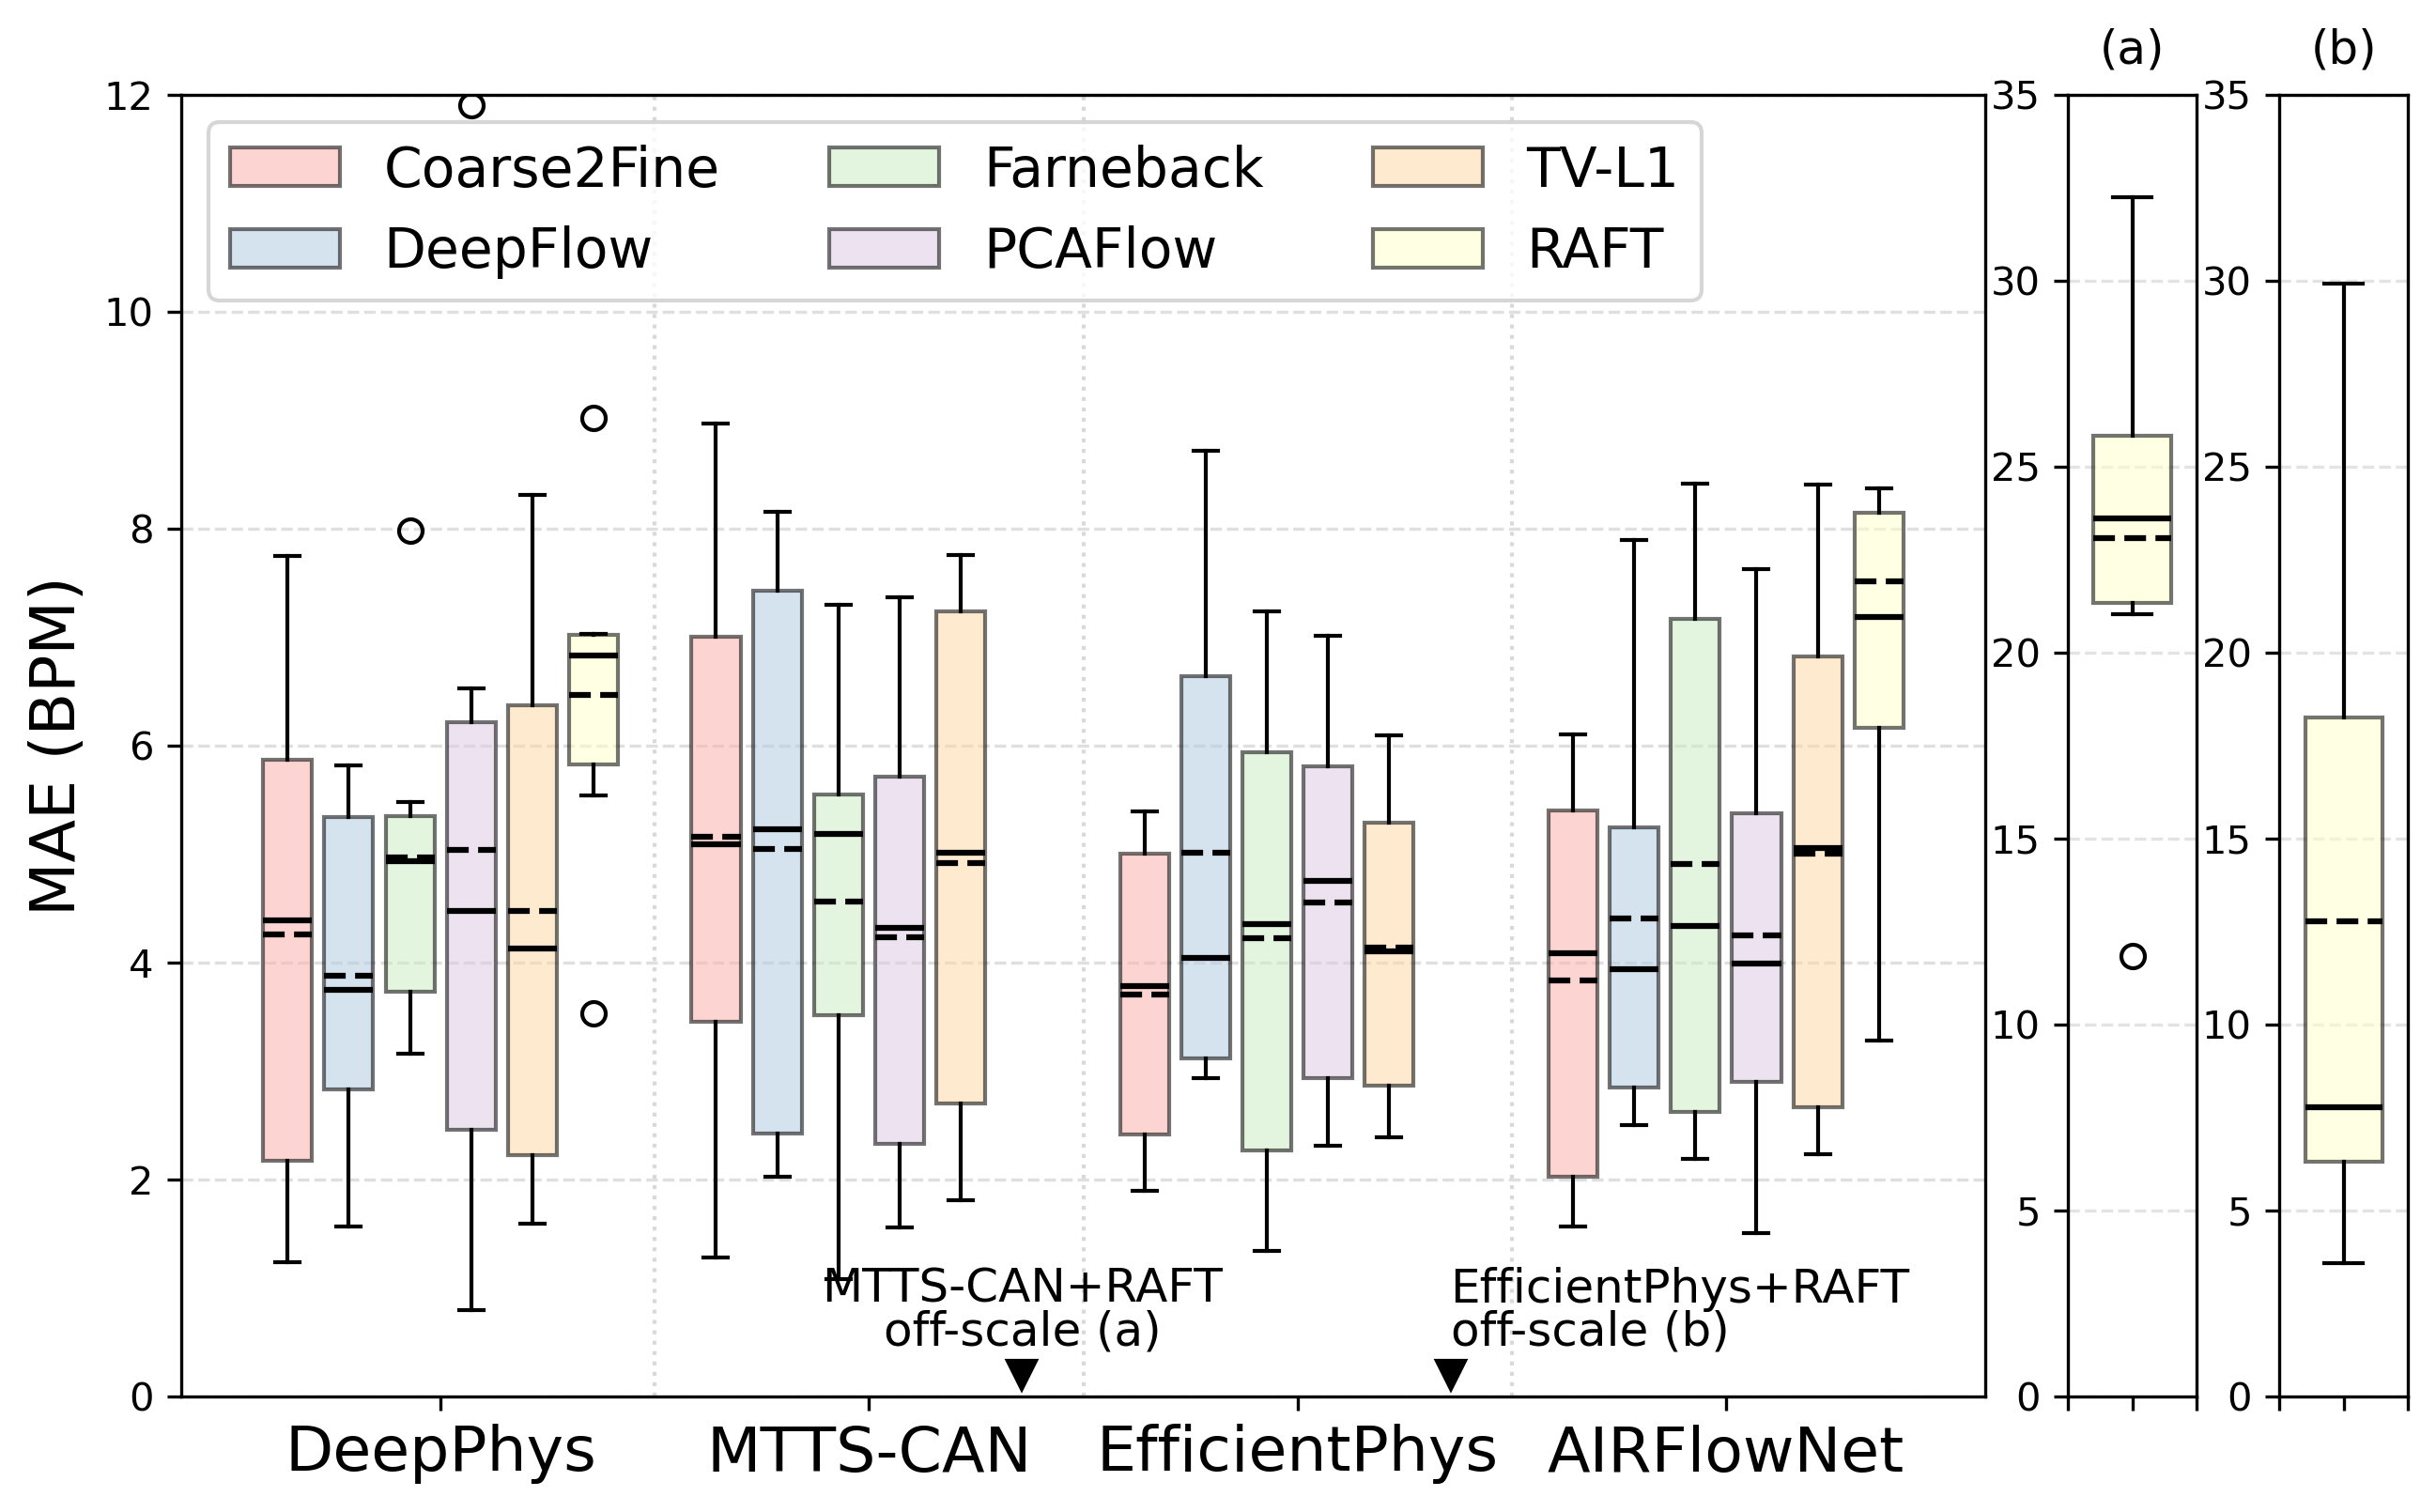

In [206]:
box_path_mae = plot_boxplots_per_method(
    df,
    y_cap=12,
    y_cap_r=(0, 35),
    metric='MAE',
    overflow_pairs=[("MTTS-CAN", "RAFT"), ("EfficientPhys", "RAFT")], 
    save_path="results/cv_results_mae.png",
    models_order=["DeepPhys","MTTS-CAN","EfficientPhys","AIRFlowNet",],
    methods_order=["Coarse2Fine","DeepFlow","Farneback","PCAFlow","TV-L1","RAFT"]
)
box_path_mae

/var/folders/fk/0g70tzjs7jb333y78dc_1jvc0000gn/T/ipykernel_27435/3249484861.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


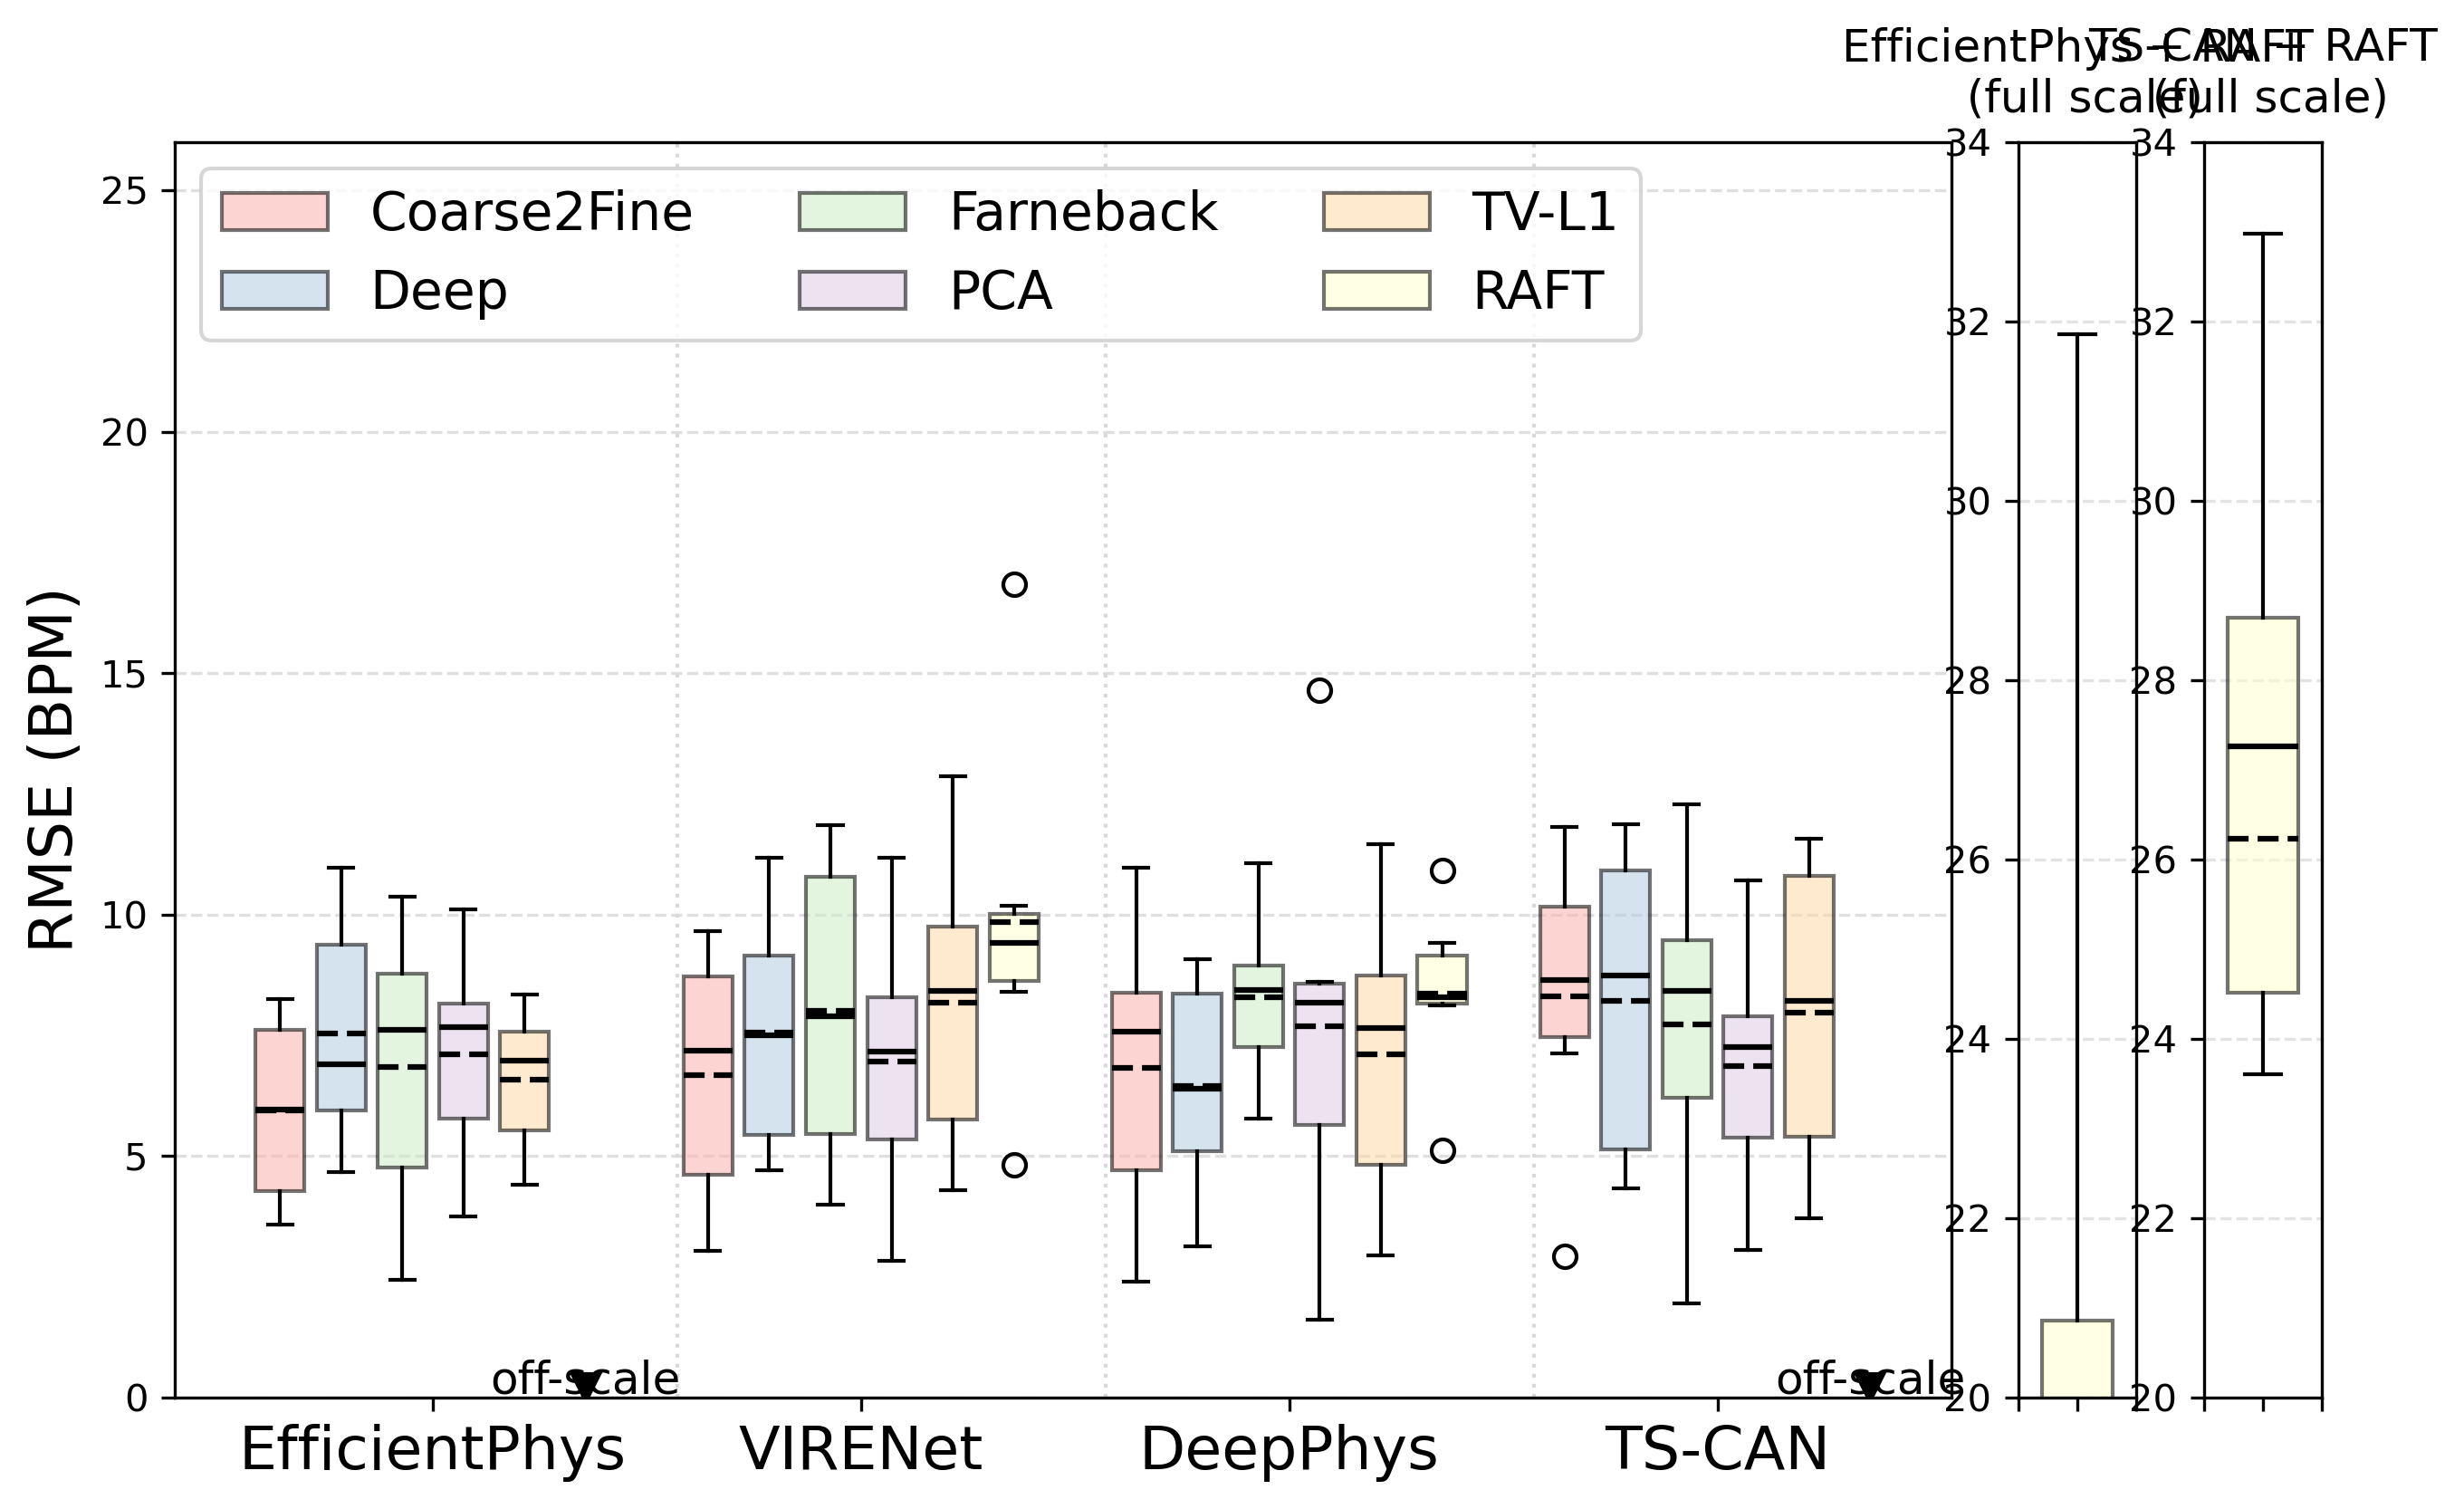

In [131]:
# box_path_rmse = plot_boxplots_per_method(
#     df,
#     y_cap=26,
#     y_cap_r=(20, 34),
#     metric='RMSE',
#     overflow_pairs=[("EfficientPhys", "RAFT"), ("TS-CAN", "RAFT")],
#     save_path="results/cv_results_rmse.png",
#     models_order=["EfficientPhys","VIRENet","DeepPhys","TS-CAN"],
#     methods_order=["Coarse2Fine","Deep","Farneback","PCA","TV-L1","RAFT"]
# )
# box_path_rmse

In [215]:
# def plot_boxplots_train_size(df, metric, models_order, save_path):
#     fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=300)
#     panel_labels = ['(a)', '(b)', '(c)', '(d)']
#
#     # --- determine global y-limits across all models ---
#     global_min, global_max = np.inf, -np.inf
#     for model in models_order:
#         vals = df.loc[df["Model"] == model, metric].dropna().to_numpy(dtype=float)
#         if len(vals) > 0:
#             global_min = min(global_min, vals.min())
#             global_max = max(global_max, vals.max())
#     # pad a little for aesthetics
#     y_min, y_max = global_min - 0.5, global_max + 0.5
#
#     for i, (ax, model, label) in enumerate(zip(axes.ravel(), models_order, panel_labels)):
#         model_df = df[df["Model"] == model]
#         train_size_names = list(model_df["Name"].drop_duplicates())
#         data  = [model_df.loc[df["Name"] == n, metric].dropna().to_numpy(dtype=float) for n in train_size_names]
#         G = len(train_size_names)
#
#         gap = 1.4  # empty slot between groups
#         centers = np.arange(G) * gap + 1.0
#
#         cmap = plt.get_cmap("Pastel1")
#         colors = [cmap(i % cmap.N) for i in range(G)]
#
#         bp = ax.boxplot(
#             data,
#             positions=centers,
#             widths=0.8,
#             showmeans=True,
#             meanline=True,
#             patch_artist=True,
#             manage_ticks=False,
#             showfliers=True,
#             whis=1.5
#         )
#
#         for patch, c in zip(bp["boxes"], colors):
#             patch.set_facecolor(c)
#             patch.set_alpha(0.55)
#             patch.set_linewidth(0)
#         for whisk in bp['whiskers']:
#             whisk.set_linewidth(1)
#         for cap in bp['caps']:
#             cap.set_linewidth(1)
#         for median in bp['medians']:
#             median.set_color('black')
#             median.set_linewidth(1)
#         for mean in bp['means']:
#             mean.set_color('black')
#             mean.set_linewidth(1)
#         # for flier in bp.get('fliers', []):
#         #flier.set_markerfacecolor(color)
#             #flier.set_markeredgecolor(color)
#
#         # --- overlay the 6-CV points with small jitter ---
#         for x0, vals, c in zip(centers, data, colors):
#             if len(vals) == 0:
#                 continue
#             xs = np.random.normal(loc=x0, scale=0, size=len(vals))  # jitter around center
#             ax.scatter(xs, vals, s=100, alpha=0.55, color="black", linewidths=0.3, zorder=3)
#
#         # X ticks at group centers with model names
#         ax.set_xticks(centers)
#         train_size_names = [name.split()[0] for name in train_size_names]
#         if i == 2 or i == 3:
#             ax.set_xticklabels(train_size_names, rotation=0, ha="center", fontsize=12)
#             ax.set_xlabel("Train Size", ha="center", fontsize=14)
#         else:
#             ax.set_xticklabels([])
#
#
#         # Optional vertical separators between groups
#         seps = (centers[:-1] + centers[1:]) / 2.0
#         for x in seps:
#             ax.axvline(x=x, color="black", linestyle="-", linewidth=1)
#
#         # Labels & grid
#         ax.set_title(model, fontsize=15, fontweight="bold")
#         if i == 0 or i == 2:
#             ax.set_ylabel(f"{metric} (BPM)", ha="center", fontsize=14)
#         else:
#             ax.set_yticklabels([])
#         ax.set_ylim(y_min, y_max)
#
#         # add panel label in top-left
#         ax.text(
#             0.02, 0.95, label,
#             transform=ax.transAxes,
#             fontsize=14,
#             fontweight="bold",
#             va="top", ha="left"
#         )
#
#     # fig.text(0.5, 0.04, "Train Size", ha="center", fontsize=14)
#     # fig.text(0.04, 0.5, f"{metric} (BPM)", va="center", rotation="vertical", fontsize=14)
#
#     plt.tight_layout()
#     plt.savefig(save_path, bbox_inches="tight", dpi=300)
#     plt.show()

In [216]:
df_train_size = pd.read_csv('results/train_size_results.csv')
df_train_size.replace("VIRENet", "AIRFlowNet", inplace=True)
df_train_size.replace("TS-CAN", "MTTS-CAN", inplace=True)
df_train_size

,Model,OF Method,ROI,Name,CV,MAE,RMSE,Rho
0,EfficientPhys,Coarse2Fine,Body,25% Train Size,0,2.323070,4.711994,0.672866
1,EfficientPhys,Coarse2Fine,Body,25% Train Size,1,5.296224,7.492278,0.432596
2,EfficientPhys,Coarse2Fine,Body,25% Train Size,2,5.192486,9.530613,0.441292
3,EfficientPhys,Coarse2Fine,Body,25% Train Size,3,3.363037,4.992482,0.646984
4,EfficientPhys,Coarse2Fine,Body,25% Train Size,4,5.101103,7.316057,0.330436
...,...,...,...,...,...,...,...,...
91,MTTS-CAN,Coarse2Fine,Body,100% Train Size,1,8.968099,11.822901,-0.029092
92,MTTS-CAN,Coarse2Fine,Body,100% Train Size,2,3.916530,8.481859,0.400425
93,MTTS-CAN,Coarse2Fine,Body,100% Train Size,3,1.281738,2.921130,0.890565
94,MTTS-CAN,Coarse2Fine,Body,100% Train Size,4,6.261489,8.824987,0.207041


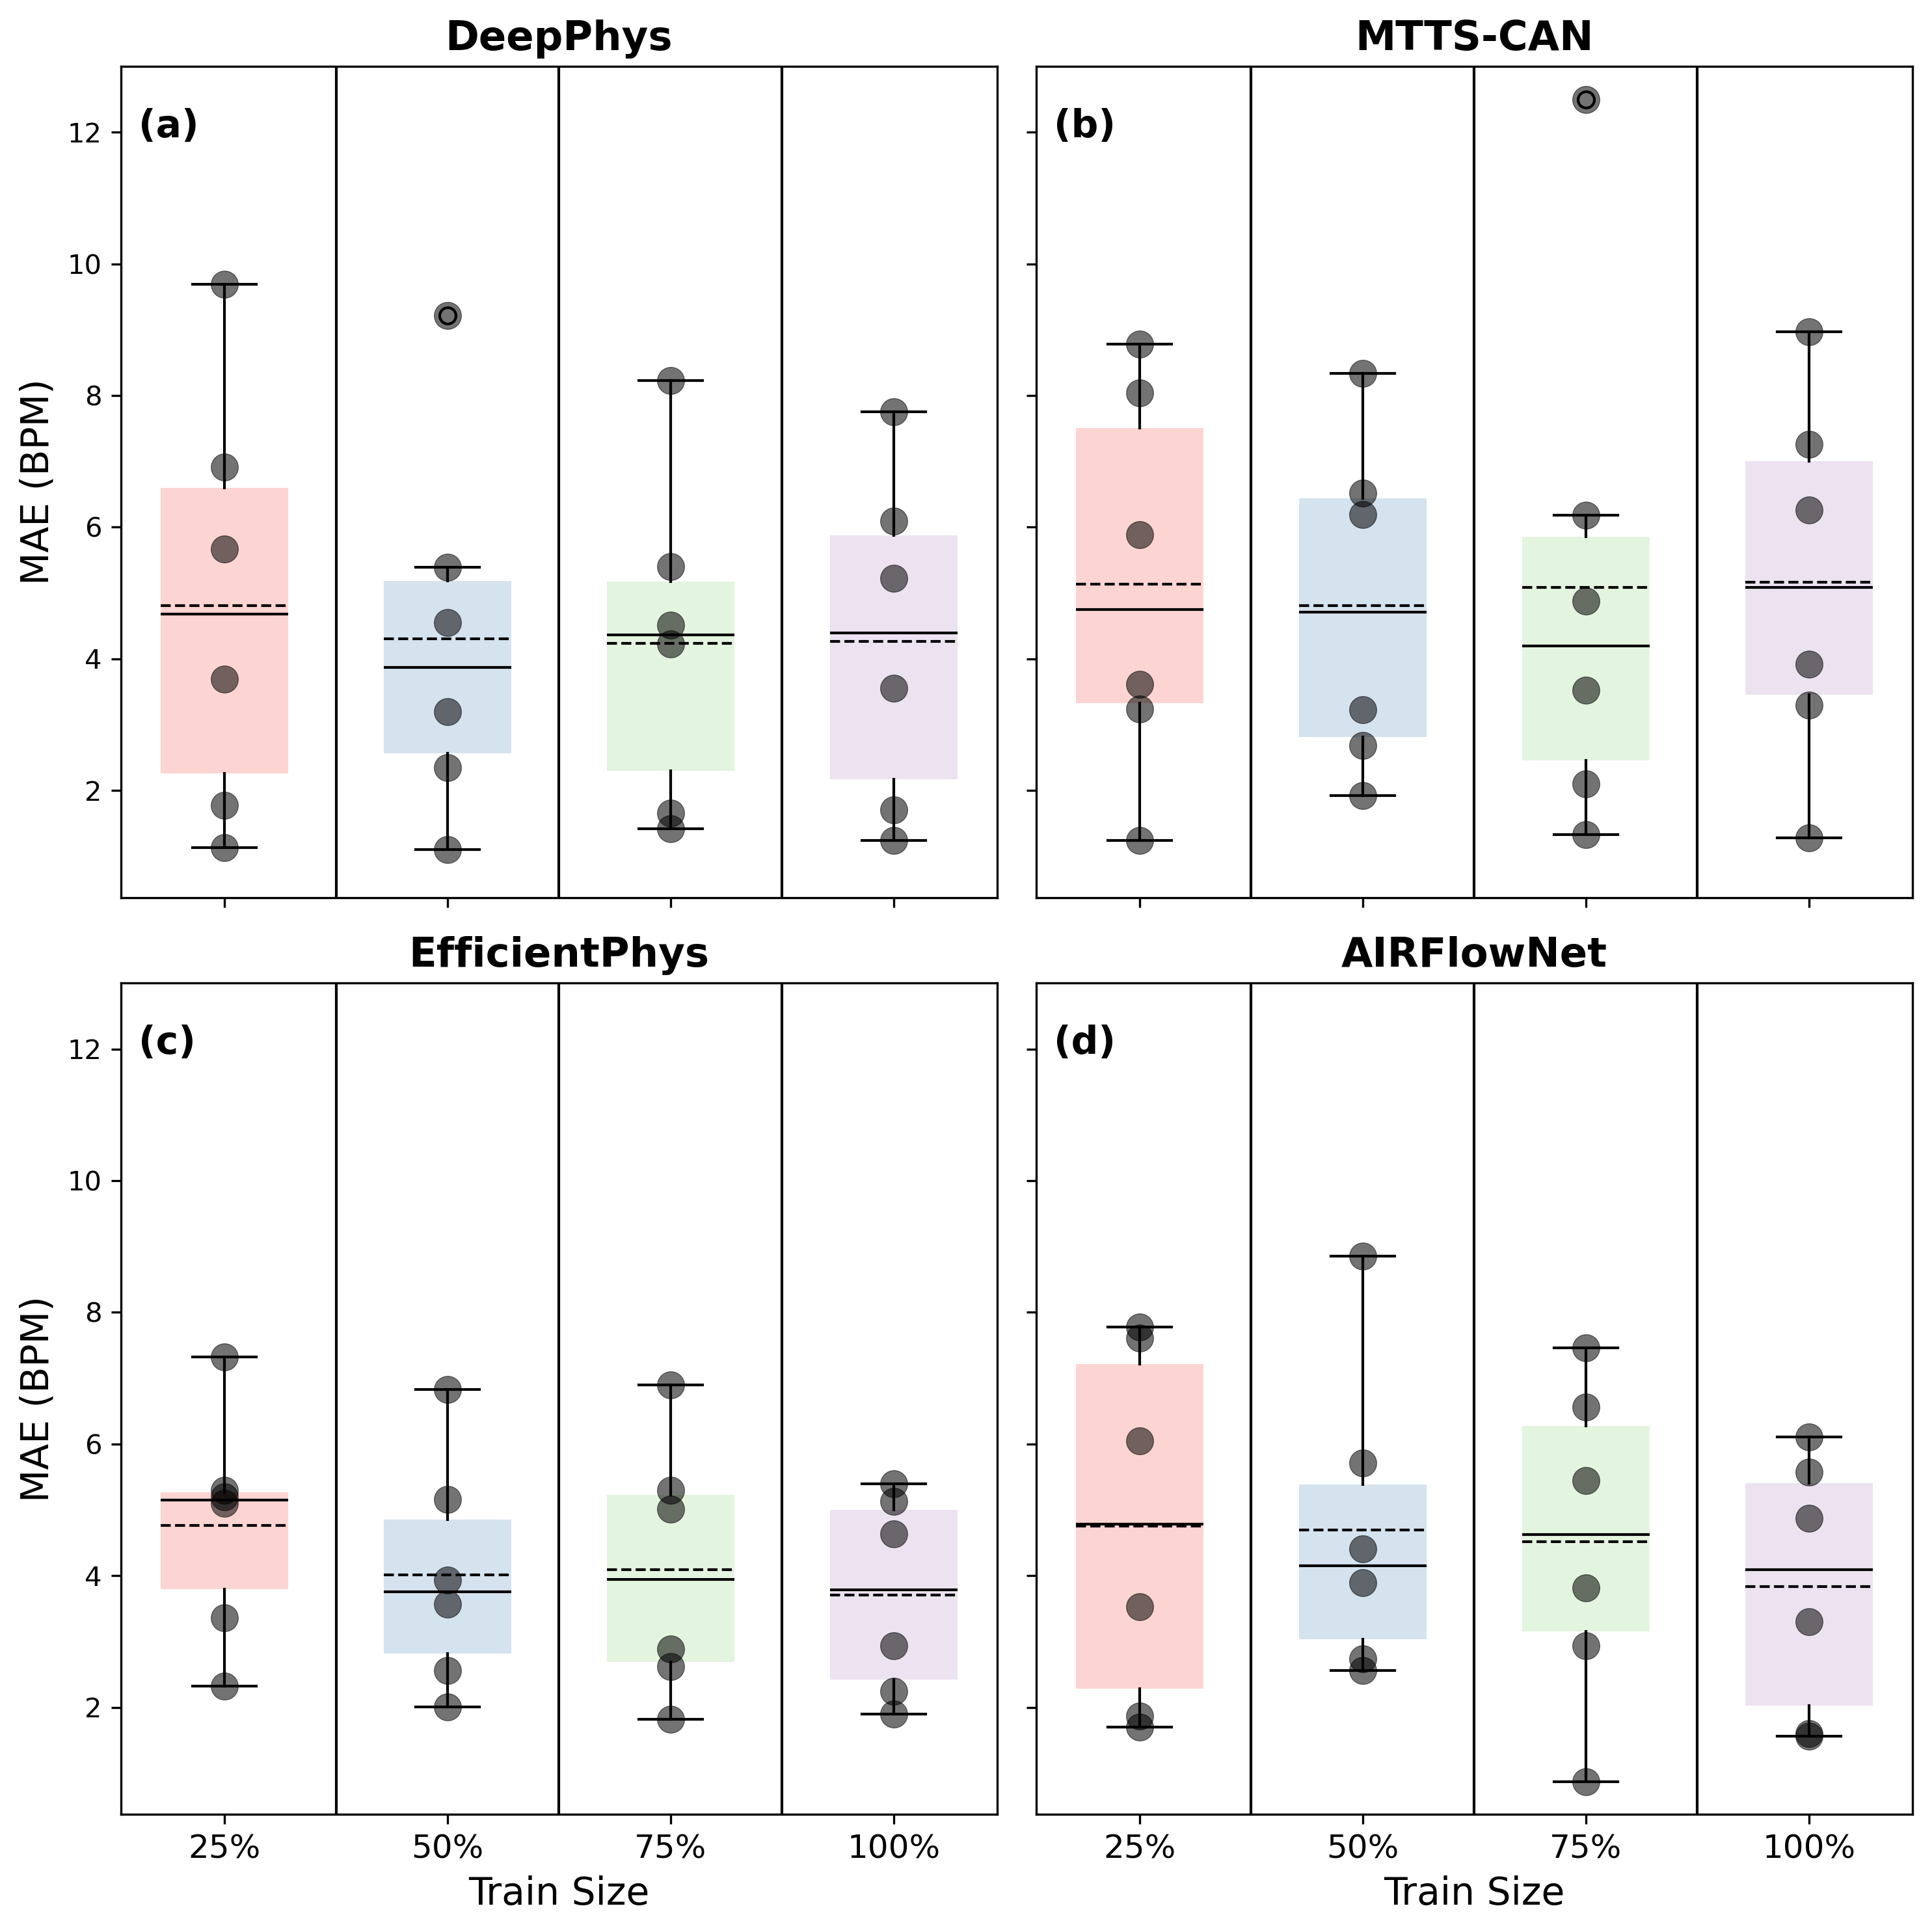

In [217]:
# df_train_size_efficientphys = df_train_size[df_train_size["Model"] == "EfficientPhys"]
# plot_boxplots_train_size(
#     df_train_size,
#     metric="MAE",
#     models_order=["DeepPhys","MTTS-CAN","EfficientPhys","AIRFlowNet",],
#     save_path="results/train_size_boxplots.png",
# )

In [349]:
def plot_train_size_lines(df, metric, models_order, save_path):
    """
    df: DataFrame with columns ["Model", "Name", metric]
        - Model: DeepPhys / TS-CAN / EfficientPhys / VIRENet
        - Name: e.g., "25% Train Size"
        - metric: e.g., "MAE", "RMSE", "r"
    """

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

    # Get unique train sizes in correct order
    train_sizes = sorted(df["Name"].unique(), key=lambda x: int(x.split("%")[0]))

    cmap = plt.get_cmap("Set1")
    model_colors = {m: cmap(i % cmap.N) for i, m in enumerate(models_order)}

    # Plot each model
    models = df["Model"].unique()
    for model in models:
        model_df = df[df["Model"] == model]
        vals_list = [model_df.loc[model_df["Name"] == ts, metric].to_numpy() for ts in train_sizes]
        means = np.array([np.nanmean(v) if len(v) else np.nan for v in vals_list])
        ax.plot(
            train_sizes,
            means,
            marker="o",
            markersize=6,
            markerfacecolor="white",
            linestyle='--',
            color = model_colors[model],
            linewidth=1.5,
            label=model,
            alpha=0.6
        )

    # Compute grand total (average across models for each train size)
    grand_total = []
    for ts in train_sizes:
        vals = (df.loc[df["Name"] == ts, ["Model", metric]]
                .groupby("Model")[metric]
                .mean())
        grand_total.append(vals.mean())

    ax.plot(
        train_sizes,
        grand_total,
        marker="o",
        markersize=6,
        linewidth=2,
        color="black",
        label="Average"
    )

    # Styling
    ax.set_ylabel(f"{metric} (BPM)", fontsize=18)
    ax.set_xlabel("Train Size", fontsize=18)
    ax.tick_params(axis='x', bottom=False, labelsize=18)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticklabels([t.split()[0] for t in train_sizes], rotation=0, ha="center")

    ax.grid(axis='x', alpha=0.5, linestyle='-')
    ax.set_ylim([3.6, 5.2])

    handles, labels = ax.get_legend_handles_labels()
    desired_label_order = ["Average"] + models_order
    ordered_handles = [h for l in desired_label_order for h, lab in zip(handles, labels) if lab == l]
    ordered_labels = desired_label_order
    ax.legend(ordered_handles, ordered_labels, fontsize=16)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


/var/folders/fk/0g70tzjs7jb333y78dc_1jvc0000gn/T/ipykernel_27435/1666149138.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.split()[0] for t in train_sizes], rotation=0, ha="center")


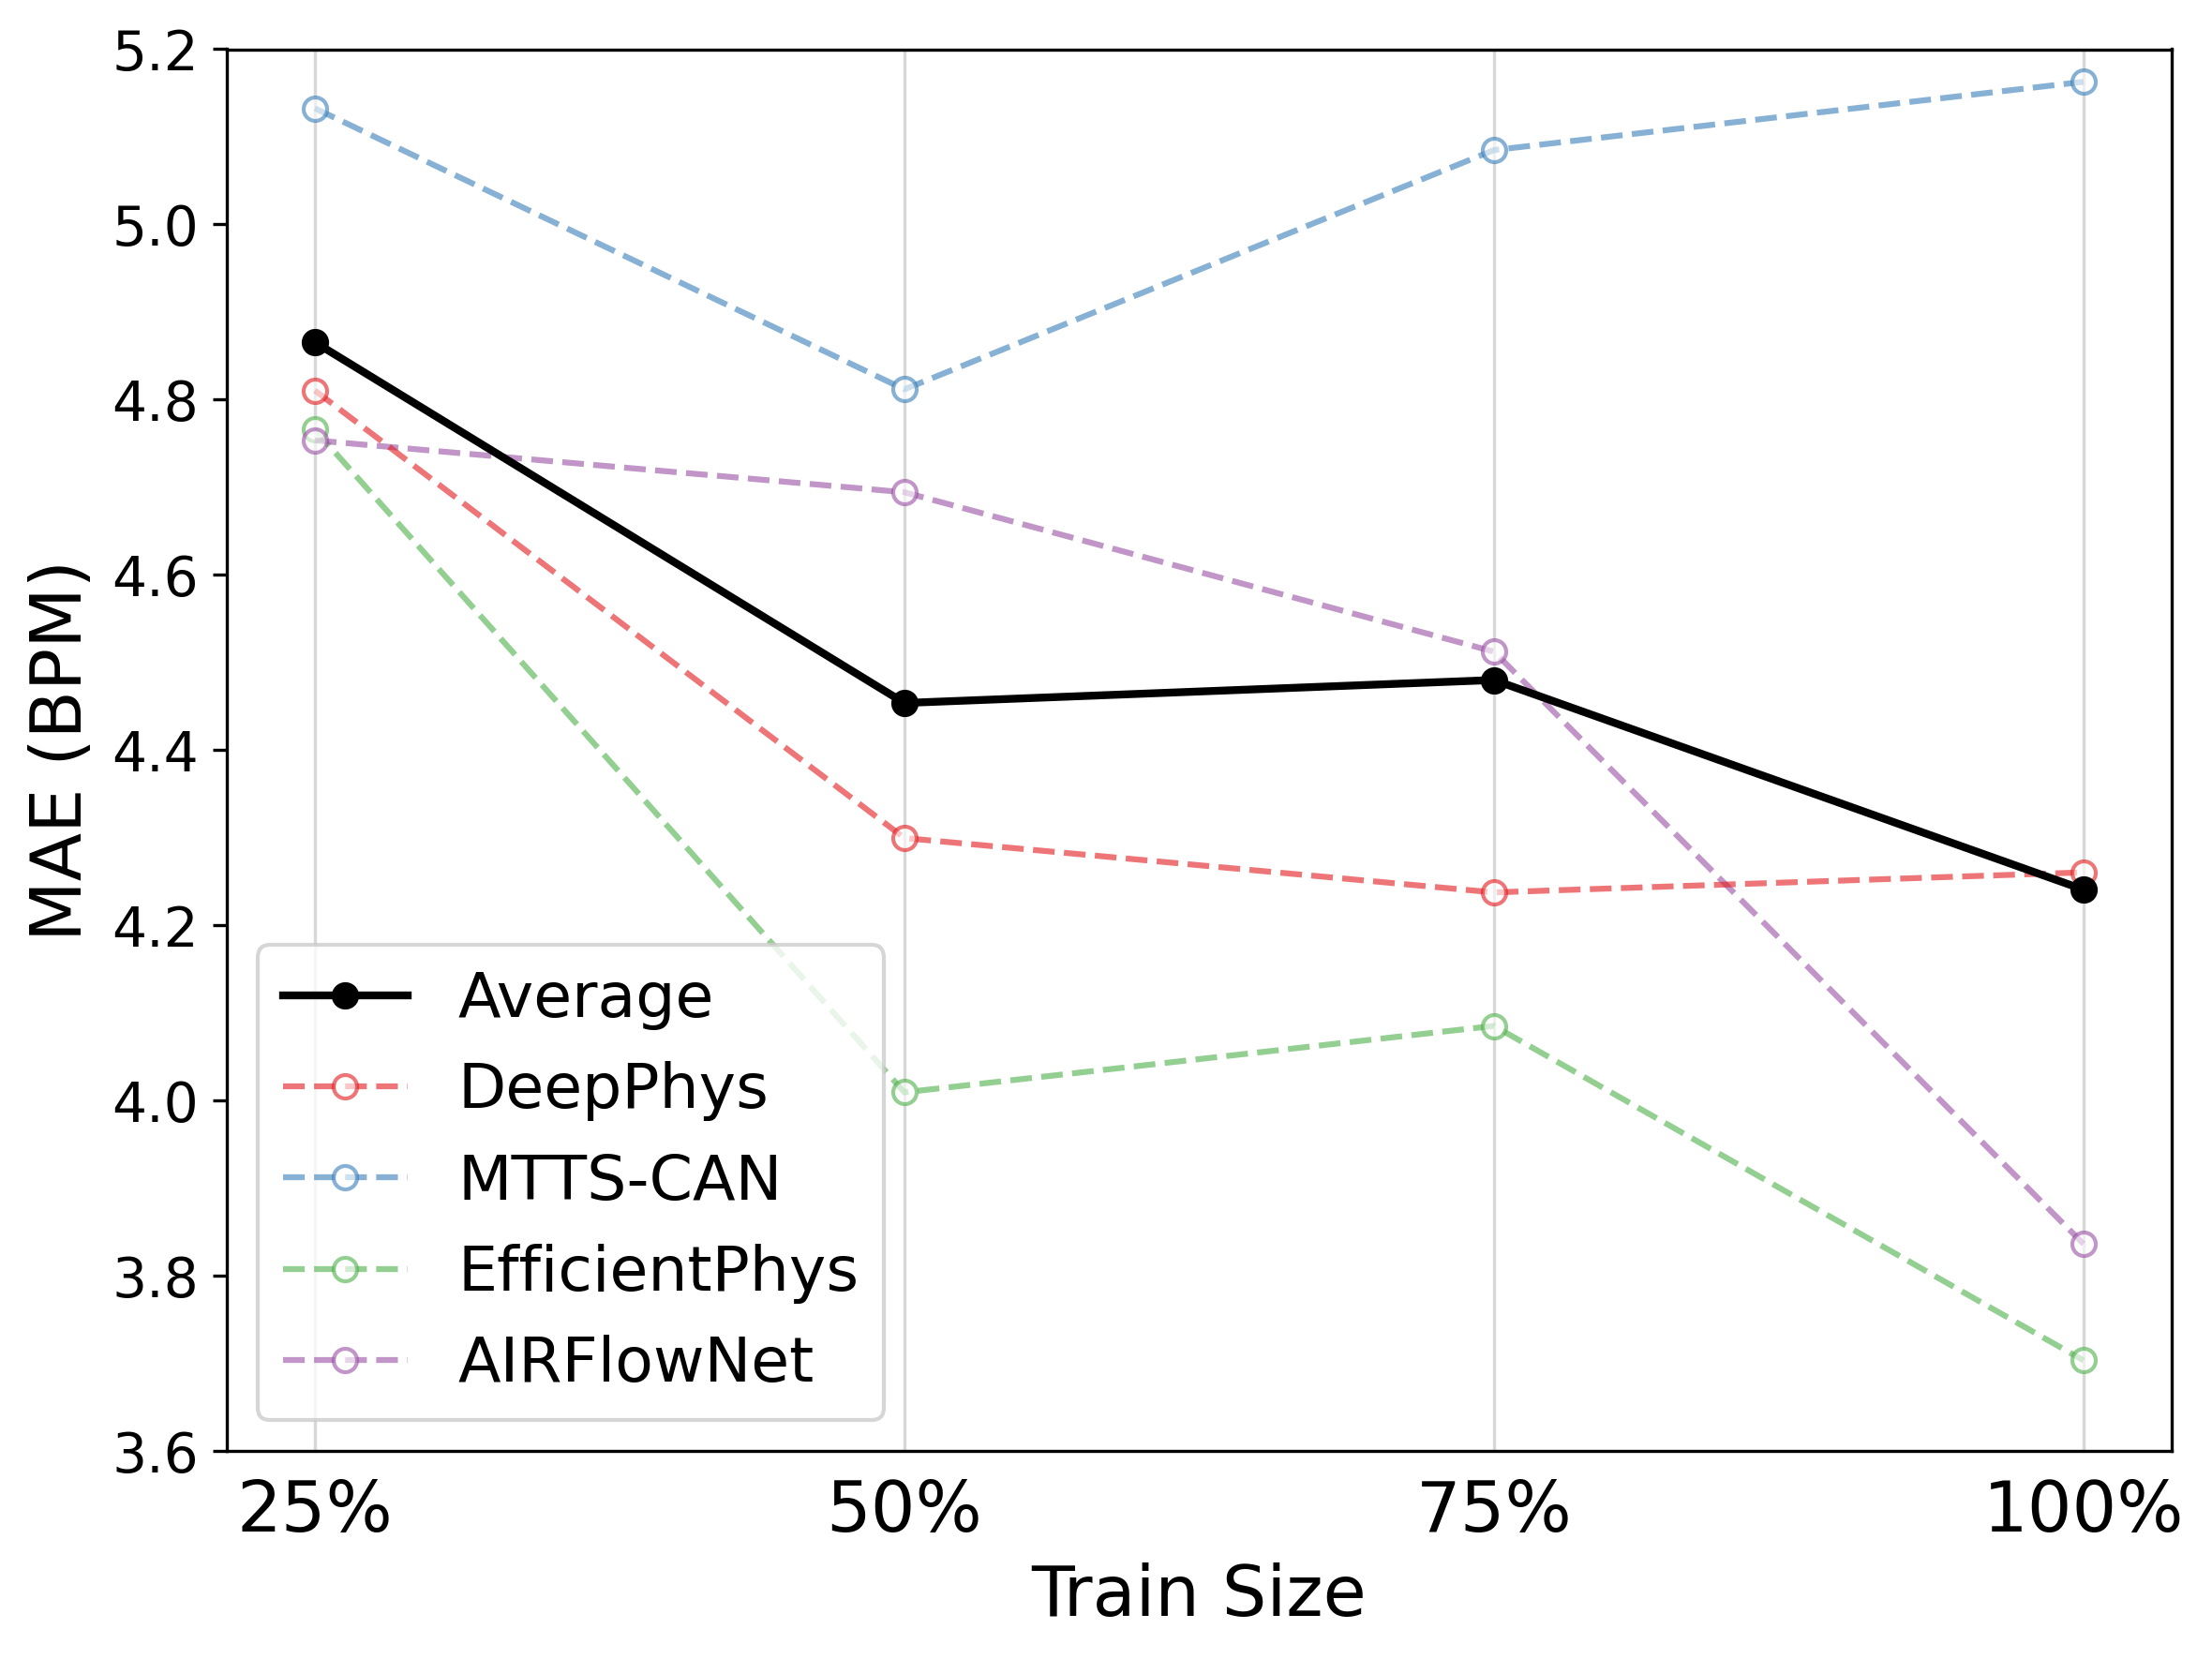

In [350]:
plot_train_size_lines(
    df_train_size,
    metric='MAE', 
    models_order=["DeepPhys","MTTS-CAN","EfficientPhys","AIRFlowNet",], 
    save_path='results/train_size_lineplots.png'
)